<a href="https://colab.research.google.com/github/tgwon/ai4ml/blob/main/project/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이브러리 import 및 설치

In [1]:
import os
import random
import joblib
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

# 음수 문제 때문에 clip 사용
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.clip(y_true, 0, None), np.clip(y_pred, 0, None)))

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [6]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.0 MB/s eta 0:00:00


In [5]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.4 MB/s eta 0:00:00


In [7]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

import xgboost as xgb
import lightgbm as lgb
import catboost as catb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet

## 데이터 준비 및 라벨 인코딩

In [144]:
train_org = pd.read_csv('/content/drive/MyDrive/ai4ml/open/final_train_df.csv')
test_org = pd.read_csv('/content/drive/MyDrive/ai4ml/open/final_test_df.csv')

train_df = train_org.copy()
test_df = test_org.copy()

In [145]:
train_df.head()

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,outlier,시군구별평균ECLO,시군구별사고발생횟수,구,동,연,월,일,시간,special_month,활동시간대,holiday,도로형태1,도로형태2,계절,설치개수,어린이보호구역점수,급지구분_1,급지구분_2,급지구분_3,cctv점수
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,0,1,0,0,5,False,4.282443,131,중구,대신동,2019,1,1,0,1,0,1,단일로,기타,겨울,391.0,2.0,11.0,0.0,0.0,3.0
1,ACCIDENT_00001,화요일,기타,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상,0,0,1,0,3,False,4.738938,678,달서구,감삼동,2019,1,1,0,1,0,1,단일로,기타,겨울,932.0,0.0,0.0,8.0,3.0,8.0
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,상해없음,보행자,남,38세,경상,0,0,1,0,3,False,4.842715,604,수성구,두산동,2019,1,1,1,1,0,1,단일로,기타,겨울,473.0,5.0,0.0,0.0,0.0,4.0
3,ACCIDENT_00003,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,49세,상해없음,승용,남,36세,중상,0,1,0,0,5,False,4.208920,426,북구,복현동,2019,1,1,2,1,0,1,단일로,기타,겨울,534.0,10.0,0.0,10.0,5.0,10.0
4,ACCIDENT_00004,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,30세,상해없음,승용,남,52세,경상,0,0,1,0,3,False,4.549091,825,동구,신암동,2019,1,1,4,1,0,1,단일로,기타,겨울,2057.0,15.0,1.0,4.0,0.0,12.0


In [146]:
test_df.head()

,ID,요일,기상상태,노면상태,사고유형,시군구별평균ECLO,시군구별사고발생횟수,구,동,연,월,일,시간,special_month,활동시간대,holiday,도로형태1,도로형태2,계절,설치개수,어린이보호구역점수,급지구분_1,급지구분_2,급지구분_3,cctv점수
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,4.881657,338,수성구,상동,2022,1,1,1,1,0,1,교차로,교차로안,겨울,700.0,5.0,0.0,0.0,0.0,4.0
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,4.563008,492,수성구,지산동,2022,1,1,1,1,0,1,단일로,기타,겨울,0.0,10.0,0.0,0.0,2.0,7.0
2,ACCIDENT_39611,토요일,맑음,건조,차대차,4.945578,147,수성구,수성동2가,2022,1,1,4,1,0,1,교차로,교차로안,겨울,0.0,1.0,0.0,0.0,0.0,1.0
3,ACCIDENT_39612,토요일,맑음,건조,차대차,4.438172,372,수성구,신매동,2022,1,1,4,1,0,1,단일로,기타,겨울,0.0,7.0,0.0,2.0,1.0,11.0
4,ACCIDENT_39613,토요일,맑음,건조,차대차,4.738938,678,달서구,감삼동,2022,1,1,6,1,1,1,교차로,교차로안,겨울,932.0,0.0,0.0,8.0,3.0,8.0


In [147]:
train_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO',
       'outlier', '시군구별평균ECLO', '시군구별사고발생횟수', '구', '동', '연', '월', '일', '시간',
       'special_month', '활동시간대', 'holiday', '도로형태1', '도로형태2', '계절', '설치개수',
       '어린이보호구역점수', '급지구분_1', '급지구분_2', '급지구분_3', 'cctv점수'],
      dtype='object')

In [148]:
test_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '시군구별평균ECLO', '시군구별사고발생횟수', '구',
       '동', '연', '월', '일', '시간', 'special_month', '활동시간대', 'holiday', '도로형태1',
       '도로형태2', '계절', '설치개수', '어린이보호구역점수', '급지구분_1', '급지구분_2', '급지구분_3',
       'cctv점수'],
      dtype='object')

In [149]:
# '연', '월', '일', '시간' 열의 dtype을 object로 변경
train_df['연'] = train_df['연'].astype(str)
train_df['월'] = train_df['월'].astype(str)
train_df['일'] = train_df['일'].astype(str)
train_df['시간'] = train_df['시간'].astype(str)

In [150]:
# '연', '월', '일', '시간' 열의 dtype을 object로 변경
test_df['연'] = test_df['연'].astype(str)
test_df['월'] = test_df['월'].astype(str)
test_df['일'] = test_df['일'].astype(str)
test_df['시간'] = test_df['시간'].astype(str)

In [151]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39573 entries, 0 to 39572
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             39573 non-null  object 
 1   요일             39573 non-null  object 
 2   기상상태           39573 non-null  object 
 3   노면상태           39573 non-null  object 
 4   사고유형           39573 non-null  object 
 5   사고유형 - 세부분류    39573 non-null  object 
 6   법규위반           39573 non-null  object 
 7   가해운전자 차종       39573 non-null  object 
 8   가해운전자 성별       39573 non-null  object 
 9   가해운전자 연령       39573 non-null  object 
 10  가해운전자 상해정도     39573 non-null  object 
 11  피해운전자 차종       39573 non-null  object 
 12  피해운전자 성별       39573 non-null  object 
 13  피해운전자 연령       39573 non-null  object 
 14  피해운전자 상해정도     39573 non-null  object 
 15  사망자수           39573 non-null  int64  
 16  중상자수           39573 non-null  int64  
 17  경상자수           39573 non-null  int64  
 18  부상자수  

In [152]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             10963 non-null  object 
 1   요일             10963 non-null  object 
 2   기상상태           10963 non-null  object 
 3   노면상태           10963 non-null  object 
 4   사고유형           10963 non-null  object 
 5   시군구별평균ECLO     10963 non-null  float64
 6   시군구별사고발생횟수     10963 non-null  int64  
 7   구              10963 non-null  object 
 8   동              10963 non-null  object 
 9   연              10963 non-null  object 
 10  월              10963 non-null  object 
 11  일              10963 non-null  object 
 12  시간             10963 non-null  object 
 13  special_month  10963 non-null  int64  
 14  활동시간대          10963 non-null  int64  
 15  holiday        10963 non-null  int64  
 16  도로형태1          10963 non-null  object 
 17  도로형태2          10963 non-null  object 
 18  계절    

In [153]:
test_x = test_df.drop(columns=['ID']).copy()

In [154]:
eclo = train_df['ECLO']

In [155]:
train_df = train_df[test_x.columns].copy()

In [156]:
train_df['ECLO'] = eclo

In [157]:
train_df.head()

,요일,기상상태,노면상태,사고유형,시군구별평균ECLO,시군구별사고발생횟수,구,동,연,월,일,시간,special_month,활동시간대,holiday,도로형태1,도로형태2,계절,설치개수,어린이보호구역점수,급지구분_1,급지구분_2,급지구분_3,cctv점수,ECLO
0,화요일,맑음,건조,차대사람,4.282443,131,중구,대신동,2019,1,1,0,1,0,1,단일로,기타,겨울,391.0,2.0,11.0,0.0,0.0,3.0,5
1,화요일,기타,건조,차대사람,4.738938,678,달서구,감삼동,2019,1,1,0,1,0,1,단일로,기타,겨울,932.0,0.0,0.0,8.0,3.0,8.0,3
2,화요일,맑음,건조,차대사람,4.842715,604,수성구,두산동,2019,1,1,1,1,0,1,단일로,기타,겨울,473.0,5.0,0.0,0.0,0.0,4.0,3
3,화요일,맑음,건조,차대차,4.208920,426,북구,복현동,2019,1,1,2,1,0,1,단일로,기타,겨울,534.0,10.0,0.0,10.0,5.0,10.0,5
4,화요일,맑음,건조,차대차,4.549091,825,동구,신암동,2019,1,1,4,1,0,1,단일로,기타,겨울,2057.0,15.0,1.0,4.0,0.0,12.0,3


In [158]:
# from sklearn.preprocessing import LabelEncoder

# labelencoder가 아니라 targerencoder 사용
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_df.dtypes[train_df.dtypes == "object"].index)

for i in categorical_features:
    le = TargetEncoder(cols=[i])
    train_df[i] = le.fit_transform(train_df[i], train_df['ECLO'])

# 추출된 문자열 변수 확인
print(categorical_features)

['요일', '기상상태', '노면상태', '사고유형', '구', '동', '연', '월', '일', '시간', '도로형태1', '도로형태2', '계절']


In [159]:
train_df.head()

,요일,기상상태,노면상태,사고유형,시군구별평균ECLO,시군구별사고발생횟수,구,동,연,월,일,시간,special_month,활동시간대,holiday,도로형태1,도로형태2,계절,설치개수,어린이보호구역점수,급지구분_1,급지구분_2,급지구분_3,cctv점수,ECLO
0,4.626747,4.711899,4.711895,3.816903,4.282443,131,4.541971,4.282449,4.840196,4.662153,4.816007,5.071256,1,0,1,4.669835,4.597547,4.655799,391.0,2.0,11.0,0.0,0.0,3.0,5
1,4.626747,4.789407,4.711895,3.816903,4.738938,678,4.617796,4.738938,4.840196,4.662153,4.816007,5.071256,1,0,1,4.669835,4.597547,4.655799,932.0,0.0,0.0,8.0,3.0,8.0,3
2,4.626747,4.711899,4.711895,3.816903,4.842715,604,4.727110,4.842715,4.840196,4.662153,4.816007,5.251121,1,0,1,4.669835,4.597547,4.655799,473.0,5.0,0.0,0.0,0.0,4.0,3
3,4.626747,4.711899,4.711895,4.943519,4.208920,426,4.687227,4.208920,4.840196,4.662153,4.816007,5.412331,1,0,1,4.669835,4.597547,4.655799,534.0,10.0,0.0,10.0,5.0,10.0,5
4,4.626747,4.711899,4.711895,4.943519,4.549091,825,4.884023,4.549091,4.840196,4.662153,4.816007,5.139726,1,0,1,4.669835,4.597547,4.655799,2057.0,15.0,1.0,4.0,0.0,12.0,3


In [160]:
X = train_df.drop('ECLO', axis=1)
y = train_df['ECLO']

## 튜닝하지 않고 단일 모델 여러개 사용해보기
- xgb : 0.45167439676085486
- lightgbm : 0.4559934162343753
- catboost : 0.46015259139708337
- randomforest : 0.48189282864157457
- decision tree : 0.6658800927113515
- linear regression : 0.4533020004797423
- knn : 0.5023579784654256
- svr : 0.4666400682792936
- elastic net : 0.46265701422234456


-> xgb, lightgbm, catboost, linear regression 에 대해서 튜닝해보자

In [161]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [162]:
model = xgb.XGBRegressor(objective = "reg:squaredlogerror",
                        eval_metric = rmsle)

In [163]:
model.fit(x_train, y_train, verbose=False, eval_set=[(x_val, y_val)])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function rmsle at 0x7fbb92c11990>, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='reg:squaredlogerror', ...)

In [164]:
score = rmsle(model.predict(x_val), y_val)
score

0.45153847375288164

### 후처리 실험

In [165]:
df = pd.concat([x_val, y_val], axis=1)
df.head()

,요일,기상상태,노면상태,사고유형,시군구별평균ECLO,시군구별사고발생횟수,구,동,연,월,일,시간,special_month,활동시간대,holiday,도로형태1,도로형태2,계절,설치개수,어린이보호구역점수,급지구분_1,급지구분_2,급지구분_3,cctv점수,ECLO
5557,4.626747,4.711899,4.711895,4.943519,4.842715,604,4.727110,4.842715,4.840196,4.646313,4.635393,4.586104,1,1,0,4.882452,5.006147,4.765971,473.0,5.0,0.0,0.0,0.0,4.0,1
6361,5.205353,4.711899,4.711895,4.943519,4.116279,86,4.541971,4.117107,4.840196,4.710635,4.701048,4.608068,0,1,1,4.669835,4.597547,4.713194,71.0,0.0,4.0,0.0,0.0,1.0,6
21701,4.559666,4.711899,4.711895,4.943519,4.864865,555,5.072694,4.864865,4.718629,4.697840,4.694079,4.608068,1,1,0,4.669835,4.597547,4.713194,940.0,11.5,0.0,0.0,14.0,39.0,5
11873,4.559666,4.711899,4.711895,3.816903,5.079498,239,4.727110,5.079498,4.840196,4.691510,4.725652,4.641166,0,1,0,4.669835,4.597547,4.760004,0.0,7.0,0.0,0.0,0.0,7.0,5
4217,4.559666,4.711899,4.711895,4.943519,4.736170,705,4.687227,4.736170,4.840196,4.785648,4.771272,4.669267,0,1,0,4.669835,4.597547,4.765971,306.0,13.0,0.0,14.0,1.0,9.0,6


In [166]:
df.shape

(3958, 25)

In [167]:
df = df.reset_index(drop=True)

In [168]:
df = pd.concat([df, pd.DataFrame(model.predict(x_val), columns=['predicted'])], axis=1)
df.head()

,요일,기상상태,노면상태,사고유형,시군구별평균ECLO,시군구별사고발생횟수,구,동,연,월,일,시간,special_month,활동시간대,holiday,도로형태1,도로형태2,계절,설치개수,어린이보호구역점수,급지구분_1,급지구분_2,급지구분_3,cctv점수,ECLO,predicted
0,4.626747,4.711899,4.711895,4.943519,4.842715,604,4.727110,4.842715,4.840196,4.646313,4.635393,4.586104,1,1,0,4.882452,5.006147,4.765971,473.0,5.0,0.0,0.0,0.0,4.0,1,4.393654
1,5.205353,4.711899,4.711895,4.943519,4.116279,86,4.541971,4.117107,4.840196,4.710635,4.701048,4.608068,0,1,1,4.669835,4.597547,4.713194,71.0,0.0,4.0,0.0,0.0,1.0,6,3.963059
2,4.559666,4.711899,4.711895,4.943519,4.864865,555,5.072694,4.864865,4.718629,4.697840,4.694079,4.608068,1,1,0,4.669835,4.597547,4.713194,940.0,11.5,0.0,0.0,14.0,39.0,5,4.467146
3,4.559666,4.711899,4.711895,3.816903,5.079498,239,4.727110,5.079498,4.840196,4.691510,4.725652,4.641166,0,1,0,4.669835,4.597547,4.760004,0.0,7.0,0.0,0.0,0.0,7.0,5,3.794314
4,4.559666,4.711899,4.711895,4.943519,4.736170,705,4.687227,4.736170,4.840196,4.785648,4.771272,4.669267,0,1,0,4.669835,4.597547,4.765971,306.0,13.0,0.0,14.0,1.0,9.0,6,4.084862


In [169]:
df.shape

(3958, 26)

In [170]:
df['index'] = df.index

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

In [182]:
df.ECLO.describe()

count    3958.000000
mean        4.776150
std         3.307723
min         1.000000
25%         3.000000
50%         3.000000
75%         6.000000
max        45.000000
Name: ECLO, dtype: float64

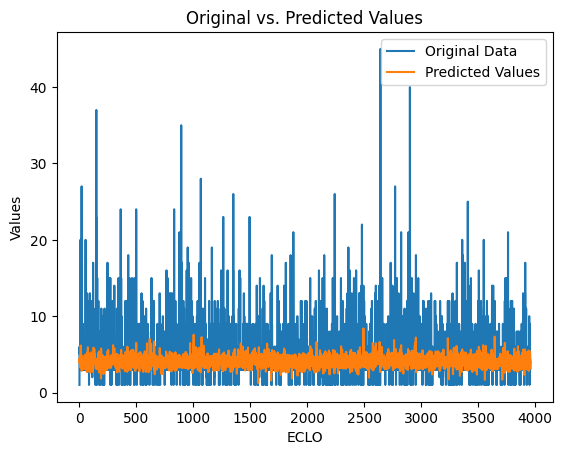

In [172]:
sns.lineplot(x='index', y='ECLO', data=df, label='Original Data')
sns.lineplot(x='index', y='predicted', data=df, label='Predicted Values')

plt.title('Original vs. Predicted Values')
plt.xlabel('ECLO')
plt.ylabel('Values')
plt.legend()
plt.show()

In [173]:
# 구,동 별로 ECLO의 평균을 계산
mean_eclo_by_group = df.groupby(['구', '동'])['ECLO'].mean().reset_index()

In [174]:
mean_eclo_by_group

,구,동,ECLO
0,4.541971,3.511013,3.736842
1,4.541971,3.806056,5.500000
2,4.541971,4.020678,4.750000
3,4.541971,4.098874,6.500000
4,4.541971,4.101759,4.333333
...,...,...,...
162,5.072694,5.319838,6.064516
163,5.072694,5.321695,5.588235
164,5.072694,5.382353,5.600000
165,5.072694,5.460122,7.200000


In [175]:
df = pd.merge(df, mean_eclo_by_group, on=['구', '동'], suffixes=('', '_mean'))

In [176]:
df.head()

,요일,기상상태,노면상태,사고유형,시군구별평균ECLO,시군구별사고발생횟수,구,동,연,월,일,시간,special_month,활동시간대,holiday,도로형태1,도로형태2,계절,설치개수,어린이보호구역점수,급지구분_1,급지구분_2,급지구분_3,cctv점수,ECLO,predicted,index,ECLO_mean
0,4.626747,4.711899,4.711895,4.943519,4.842715,604,4.72711,4.842715,4.840196,4.646313,4.635393,4.586104,1,1,0,4.882452,5.006147,4.765971,473.0,5.0,0.0,0.0,0.0,4.0,1,4.393654,0,5.241379
1,4.600194,4.711899,4.711895,3.816903,4.842715,604,4.72711,4.842715,4.840196,4.534562,4.741132,4.985388,1,0,0,4.669835,4.597547,4.655799,473.0,5.0,0.0,0.0,0.0,4.0,3,3.147061,86,5.241379
2,4.559666,4.711899,4.711895,3.996948,4.842715,604,4.72711,4.842715,4.595892,4.734682,4.669207,4.667286,0,1,0,4.065962,4.597547,4.760004,473.0,5.0,0.0,0.0,0.0,4.0,6,2.696924,117,5.241379
3,4.559666,4.711899,4.711895,3.996948,4.842715,604,4.72711,4.842715,4.840196,4.854423,4.707611,4.780447,0,1,0,4.065962,4.597547,4.760004,473.0,5.0,0.0,0.0,0.0,4.0,1,3.374970,199,5.241379
4,4.627431,4.711899,4.711895,3.816903,4.842715,604,4.72711,4.842715,4.840196,4.785648,4.596244,4.660895,0,1,0,4.669835,4.597547,4.765971,473.0,5.0,0.0,0.0,0.0,4.0,5,3.476142,356,5.241379


In [177]:
# 예측값이 평균보다 작은 경우, 평균값으로 대체

df['predicted_new'] = df[['predicted', 'ECLO_mean']].max(axis=1)
df.head()

,요일,기상상태,노면상태,사고유형,시군구별평균ECLO,시군구별사고발생횟수,구,동,연,월,일,시간,special_month,활동시간대,holiday,도로형태1,도로형태2,계절,설치개수,어린이보호구역점수,급지구분_1,급지구분_2,급지구분_3,cctv점수,ECLO,predicted,index,ECLO_mean,predicted_new
0,4.626747,4.711899,4.711895,4.943519,4.842715,604,4.72711,4.842715,4.840196,4.646313,4.635393,4.586104,1,1,0,4.882452,5.006147,4.765971,473.0,5.0,0.0,0.0,0.0,4.0,1,4.393654,0,5.241379,5.241379
1,4.600194,4.711899,4.711895,3.816903,4.842715,604,4.72711,4.842715,4.840196,4.534562,4.741132,4.985388,1,0,0,4.669835,4.597547,4.655799,473.0,5.0,0.0,0.0,0.0,4.0,3,3.147061,86,5.241379,5.241379
2,4.559666,4.711899,4.711895,3.996948,4.842715,604,4.72711,4.842715,4.595892,4.734682,4.669207,4.667286,0,1,0,4.065962,4.597547,4.760004,473.0,5.0,0.0,0.0,0.0,4.0,6,2.696924,117,5.241379,5.241379
3,4.559666,4.711899,4.711895,3.996948,4.842715,604,4.72711,4.842715,4.840196,4.854423,4.707611,4.780447,0,1,0,4.065962,4.597547,4.760004,473.0,5.0,0.0,0.0,0.0,4.0,1,3.374970,199,5.241379,5.241379
4,4.627431,4.711899,4.711895,3.816903,4.842715,604,4.72711,4.842715,4.840196,4.785648,4.596244,4.660895,0,1,0,4.669835,4.597547,4.765971,473.0,5.0,0.0,0.0,0.0,4.0,5,3.476142,356,5.241379,5.241379


In [106]:
df.head()

,요일,기상상태,노면상태,사고유형,시군구별평균ECLO,시군구별사고발생횟수,구,동,연,월,일,시간,special_month,활동시간대,holiday,도로형태1,도로형태2,계절,설치개수,어린이보호구역점수,급지구분_1,급지구분_2,급지구분_3,cctv점수,ECLO,predicted,index
0,4.626747,4.711899,4.711895,4.943519,4.842715,604,4.72711,4.842715,4.840196,4.646313,4.635393,4.586104,1,1,0,4.882452,5.006147,4.765971,473.0,5.0,0.0,0.0,0.0,4.0,1,4.393654,0
1,4.600194,4.711899,4.711895,3.816903,4.842715,604,4.72711,4.842715,4.840196,4.534562,4.741132,4.985388,1,0,0,4.669835,4.597547,4.655799,473.0,5.0,0.0,0.0,0.0,4.0,3,3.147061,86
2,4.559666,4.711899,4.711895,3.996948,4.842715,604,4.72711,4.842715,4.595892,4.734682,4.669207,4.667286,0,1,0,4.065962,4.597547,4.760004,473.0,5.0,0.0,0.0,0.0,4.0,6,2.696924,117
3,4.559666,4.711899,4.711895,3.996948,4.842715,604,4.72711,4.842715,4.840196,4.854423,4.707611,4.780447,0,1,0,4.065962,4.597547,4.760004,473.0,5.0,0.0,0.0,0.0,4.0,1,3.374970,199
4,4.627431,4.711899,4.711895,3.816903,4.842715,604,4.72711,4.842715,4.840196,4.785648,4.596244,4.660895,0,1,0,4.669835,4.597547,4.765971,473.0,5.0,0.0,0.0,0.0,4.0,5,3.476142,356


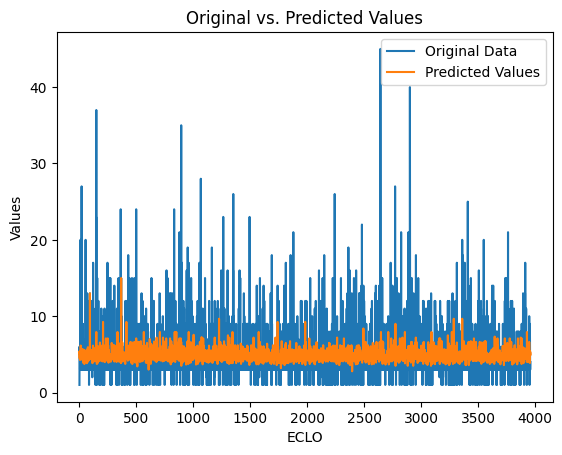

In [178]:
sns.lineplot(x='index', y='ECLO', data=df, label='Original Data')
sns.lineplot(x='index', y='predicted_new', data=df, label='Predicted Values')

plt.title('Original vs. Predicted Values')
plt.xlabel('index')
plt.ylabel('Values')
plt.legend()
plt.show()

In [179]:
score = rmsle(df.predicted_new, y_val)
score

0.48241929983381715

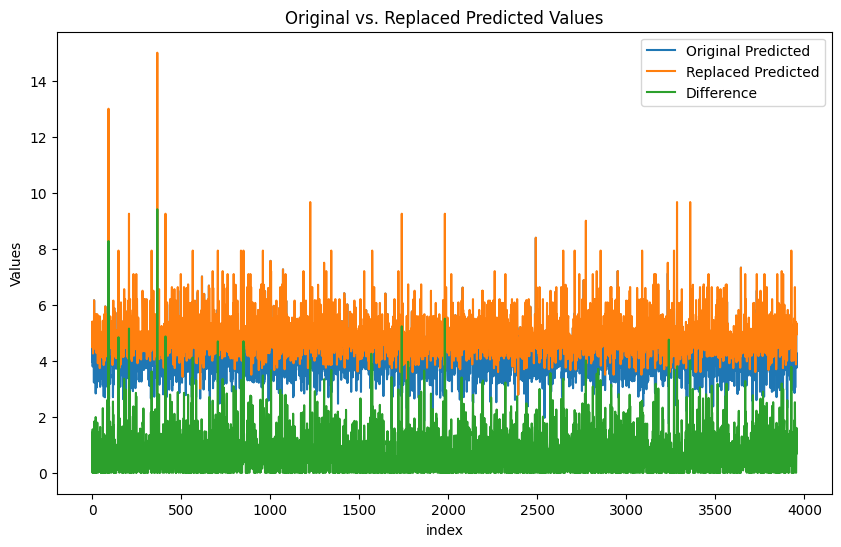

In [181]:
df['difference'] = df['predicted_new'] - df['predicted']

# 시각화
plt.figure(figsize=(10, 6))

# 예측값과 대치된 값, 차이값 시각화
sns.lineplot(x='index', y='predicted', data=df, label='Original Predicted')
sns.lineplot(x='index', y='predicted_new', data=df, label='Replaced Predicted')
sns.lineplot(x='index', y='difference', data=df, label='Difference')

plt.title('Original vs. Replaced Predicted Values')
plt.xlabel('index')
plt.ylabel('Values')
plt.legend()
plt.show()

In [185]:
# Calculate RMSLE between mean of 'ECLO' and y_val
mean_eclo = df['ECLO'].mean()
rmsle_score = np.sqrt(mean_squared_log_error(y_val, np.full_like(y_val, mean_eclo)))

print(rmsle_score)

0.45547518199066206


In [186]:
# ECLO의 중앙값 계산
eclo_median = df['ECLO'].median()

# predicted가 ECLO의 중앙값보다 작은 경우 중앙값으로 대체
df.loc[df['predicted'] < eclo_median, 'predicted'] = eclo_median

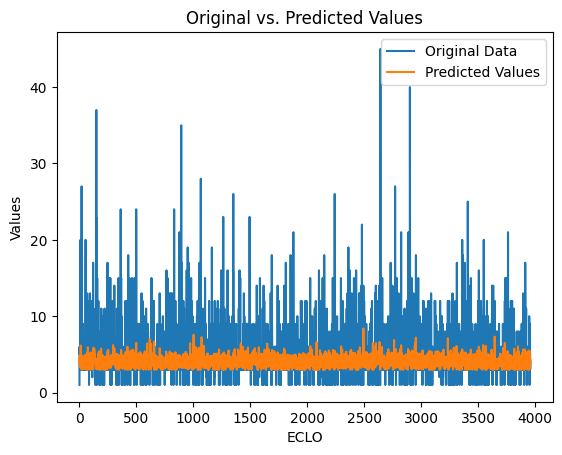

In [187]:
sns.lineplot(x='index', y='ECLO', data=df, label='Original Data')
sns.lineplot(x='index', y='predicted', data=df, label='Predicted Values')

plt.title('Original vs. Predicted Values')
plt.xlabel('ECLO')
plt.ylabel('Values')
plt.legend()
plt.show()

In [188]:
score = rmsle(df.predicted, y_val)
score

0.4701228854702845

### 모델링 이어서

In [ ]:
# LightGBM 데이터셋 생성
train_data = lgb.Dataset(x_train, label=y_train)

model = lgb.train({'objective': 'regression',
        'metric': 'rmsle'},
          train_data)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 24
[LightGBM] [Info] Start training from score 4.712837


In [ ]:
score = rmsle(model.predict(x_val), y_val)
score

0.4559934162343753

In [ ]:
model = catb.CatBoostRegressor(loss_function='RMSE')

model.fit(x_train, y_train)

Learning rate set to 0.070673
0:	learn: 3.1682782	total: 7.69ms	remaining: 7.68s
1:	learn: 3.1611188	total: 13.4ms	remaining: 6.71s
2:	learn: 3.1553426	total: 19.7ms	remaining: 6.54s
3:	learn: 3.1494053	total: 25.8ms	remaining: 6.42s
4:	learn: 3.1444209	total: 32.1ms	remaining: 6.39s
5:	learn: 3.1404841	total: 38.2ms	remaining: 6.32s
6:	learn: 3.1364793	total: 44.4ms	remaining: 6.29s
7:	learn: 3.1329237	total: 50.6ms	remaining: 6.28s
8:	learn: 3.1301912	total: 56.6ms	remaining: 6.23s
9:	learn: 3.1267479	total: 62.4ms	remaining: 6.18s
10:	learn: 3.1243474	total: 69.1ms	remaining: 6.21s
11:	learn: 3.1220207	total: 75.2ms	remaining: 6.19s
12:	learn: 3.1196307	total: 81.6ms	remaining: 6.19s
13:	learn: 3.1174165	total: 89.1ms	remaining: 6.28s
14:	learn: 3.1150762	total: 95.3ms	remaining: 6.26s
15:	learn: 3.1133637	total: 101ms	remaining: 6.24s
16:	learn: 3.1114885	total: 108ms	remaining: 6.25s
17:	learn: 3.1101308	total: 114ms	remaining: 6.25s
18:	learn: 3.1086122	total: 121ms	remaining: 6.

In [ ]:
score = rmsle(model.predict(x_val), y_val)
score

0.46015259139708337

In [ ]:
model = RandomForestRegressor(random_state=42)

model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
score = rmsle(model.predict(x_val), y_val)
score

0.48189282864157457

In [ ]:
model = DecisionTreeRegressor(random_state=42)

model.fit(x_train, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
score = rmsle(model.predict(x_val), y_val)
score

0.6658800927113515

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

model = LinearRegression()

model.fit(x_train_scaled, y_train)

LinearRegression()

In [ ]:
score = rmsle(model.predict(x_val_scaled), y_val)
score

0.4533020004797423

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(x_train_scaled, y_train)

KNeighborsRegressor()

In [ ]:
score = rmsle(knn_model.predict(x_val_scaled), y_val)
score

0.5023579784654256

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

svr_model = SVR()

svr_model.fit(x_train_scaled, y_train)

SVR()

In [ ]:
score = rmsle(svr_model.predict(x_val_scaled), y_val)
score

0.4666400682792936

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

model = ElasticNet()

model.fit(x_train_scaled, y_train)

ElasticNet()

In [ ]:
score = rmsle(model.predict(x_val_scaled), y_val)
score

0.46265701422234456

## xgb 튜닝 by optuna = 0.44278902343638393
params {'n_estimators': 976, 'max_depth': 15, 'min_child_weight': 3, 'gamma': 1, 'colsample_bytree': 0.6, 'lambda': 0.0035870167172528406, 'alpha': 0.004068582739390227, 'subsample': 0.6}

In [ ]:
def objectiveXGB(trial: Trial, X, y):
    param = {
        "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
        'max_depth':trial.suggest_int('max_depth', 8, 16),
        'min_child_weight':trial.suggest_int('min_child_weight', 1, 300),
        'gamma':trial.suggest_int('gamma', 1, 3),
        'learning_rate': 0.01,
        'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.5, 1, 0.1),
        'nthread' : -1,
        #'tree_method': 'gpu_hist',
        #'predictor': 'gpu_predictor',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'subsample': trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0] ),
        'random_state': 42
    }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    model = xgb.XGBRegressor(**param,
                             objective = "reg:squaredlogerror",
                             eval_metric = rmsle)

    xgb_model = model.fit(X_train, y_train, verbose=False, eval_set=[(X_test, y_test)])
    score = rmsle(xgb_model.predict(X_test), y_test)

    return score

In [ ]:
def train(model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = model.fit(X_train, y_train, early_stopping_rounds=100, verbose=False, eval_set=[(X_test, y_test)])
    score = rmsle(model.predict(X_test), y_test)
    print(score)

    return model, score

In [ ]:
study = optuna.create_study(direction='minimize',sampler=TPESampler())
study.optimize(lambda trial : objectiveXGB(trial, X,  y), n_trials=50)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

best_param = study.best_trial.params
xgbReg, xgbscore = train(xgb.XGBRegressor(**best_param,
                             objective = "reg:squaredlogerror",
                             eval_metric = rmsle))

[I 2023-12-13 11:22:44,765] A new study created in memory with name: no-name-97e0af94-171a-42e8-b2ba-2c734df93fe4
[I 2023-12-13 11:22:54,129] Trial 0 finished with value: 0.44462992449016725 and parameters: {'n_estimators': 577, 'max_depth': 8, 'min_child_weight': 274, 'gamma': 3, 'colsample_bytree': 0.9, 'lambda': 5.167430206811046, 'alpha': 0.04460271882002158, 'subsample': 1.0}. Best is trial 0 with value: 0.44462992449016725.
[I 2023-12-13 11:23:08,349] Trial 1 finished with value: 0.4433733570992552 and parameters: {'n_estimators': 1040, 'max_depth': 9, 'min_child_weight': 158, 'gamma': 2, 'colsample_bytree': 0.5, 'lambda': 0.050783716365577505, 'alpha': 0.04223024812658837, 'subsample': 0.8}. Best is trial 1 with value: 0.4433733570992552.
[I 2023-12-13 11:23:26,789] Trial 2 finished with value: 0.4428184045400039 and parameters: {'n_estimators': 1609, 'max_depth': 8, 'min_child_weight': 22, 'gamma': 3, 'colsample_bytree': 0.7, 'lambda': 0.7381532408384038, 'alpha': 0.02711749596

Best trial: score 0.442169944622116,
params {'n_estimators': 976, 'max_depth': 15, 'min_child_weight': 3, 'gamma': 1, 'colsample_bytree': 0.6, 'lambda': 0.0035870167172528406, 'alpha': 0.004068582739390227, 'subsample': 0.6}
0.44278902343638393


In [ ]:
# 모델 저장
#joblib.dump(xgbReg, '/content/drive/MyDrive/ai4ml/open/xgboost_model.joblib')

# 모델 로드
loaded_model = joblib.load('/content/drive/MyDrive/ai4ml/open/xgboost_model.joblib')

In [ ]:
score = rmsle(loaded_model.predict(x_val), y_val)
score

0.44278902343638393

In [ ]:
xgbscore

0.44278902343638393

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

In [ ]:
# 파라미터들관의 관계
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# 각 파라미터들의 상관관계
optuna.visualization.plot_contour(
    study,
    params=[
        "n_estimators",
        'max_depth',
        'min_child_weight',
        'gamma',
        'colsample_bytree',
        'lambda',
        'alpha',
        'subsample'
    ],
)

In [ ]:
# Display feature importances
feature_importances = xgbReg.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
3,사고유형,0.186425
4,시군구별평균ECLO,0.052780
14,holiday,0.049305
7,동,0.047140
13,활동시간대,0.045335
11,시간,0.043904
16,도로형태2,0.041667
0,요일,0.039215
21,급지구분_2,0.037248
1,기상상태,0.036104


In [ ]:
sel_features = feature_importance_df[feature_importance_df['Importance']>0]['Feature']
sel_features

3           사고유형
4     시군구별평균ECLO
14       holiday
7              동
13         활동시간대
11            시간
16         도로형태2
0             요일
21        급지구분_2
1           기상상태
6              구
9              월
15         도로형태1
20        급지구분_1
10             일
23        cctv점수
8              연
18          설치개수
2           노면상태
22        급지구분_3
5     시군구별사고발생횟수
19     어린이보호구역점수
17            계절
Name: Feature, dtype: object

## 변수 선택 (special_month 제거) + xgb 튜닝 by optuna = 0.4421654766663897
params {'n_estimators': 3781, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 2, 'colsample_bytree': 0.7, 'lambda': 0.0022933166776386055, 'alpha': 0.011454490593783234, 'subsample': 0.8}

In [ ]:
# special_month 제거
X = X[sel_features]

In [ ]:
# 학습(train), 검증(validation), 시험(test) 세트로 나누기
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
study = optuna.create_study(direction='minimize',sampler=TPESampler())
study.optimize(lambda trial : objectiveXGB(trial, X,  y), n_trials=50)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

best_param = study.best_trial.params
xgbReg, xgbscore = train(xgb.XGBRegressor(**best_param,
                             objective = "reg:squaredlogerror",
                             eval_metric = rmsle))

[I 2023-12-13 11:48:21,882] A new study created in memory with name: no-name-c9c05f5e-9188-4174-b784-1da8af5f8589
[I 2023-12-13 11:48:29,066] Trial 0 finished with value: 0.44378942342311645 and parameters: {'n_estimators': 635, 'max_depth': 10, 'min_child_weight': 117, 'gamma': 3, 'colsample_bytree': 0.8, 'lambda': 0.007900488491053993, 'alpha': 0.02702638481760807, 'subsample': 1.0}. Best is trial 0 with value: 0.44378942342311645.
[I 2023-12-13 11:49:04,079] Trial 1 finished with value: 0.4431014540594551 and parameters: {'n_estimators': 2203, 'max_depth': 9, 'min_child_weight': 148, 'gamma': 1, 'colsample_bytree': 0.6, 'lambda': 0.6102971805791696, 'alpha': 0.0035194352153705756, 'subsample': 0.7}. Best is trial 1 with value: 0.4431014540594551.
[I 2023-12-13 11:50:07,950] Trial 2 finished with value: 0.4438780464578358 and parameters: {'n_estimators': 3247, 'max_depth': 14, 'min_child_weight': 248, 'gamma': 3, 'colsample_bytree': 0.9, 'lambda': 0.5528688865809315, 'alpha': 0.06947

Best trial: score 0.4421847099452187,
params {'n_estimators': 3781, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 2, 'colsample_bytree': 0.7, 'lambda': 0.0022933166776386055, 'alpha': 0.011454490593783234, 'subsample': 0.8}
0.4421654766663897


In [ ]:
# 모델 저장
# joblib.dump(xgbReg, '/content/drive/MyDrive/ai4ml/open/xgboost_model_aftervs.joblib')

# 모델 로드
loaded_model = joblib.load('/content/drive/MyDrive/ai4ml/open/xgboost_model_aftervs.joblib')

In [ ]:
score = rmsle(loaded_model.predict(x_val), y_val)
score

0.4421654766663897

In [ ]:
xgbscore

0.4421654766663897

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

In [ ]:
# 파라미터들관의 관계
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# 각 파라미터들의 상관관계
optuna.visualization.plot_contour(
    study,
    params=[
        "n_estimators",
        'max_depth',
        'min_child_weight',
        'gamma',
        'colsample_bytree',
        'lambda',
        'alpha',
        'subsample'
    ],
)

## LGBM 튜닝 by optuna = 0.4555993551462616
params {'lambda_l1': 7.758984283606905e-07, 'lambda_l2': 0.07324518486756167, 'num_leaves': 17, 'n_estimators': 1539, 'feature_fraction': 0.534757703078947, 'bagging_fraction': 0.8243555882184129, 'bagging_freq': 5, 'min_child_samples': 81}

In [ ]:
def objectiveLGBM(trial: Trial, X, y):
    param = {
        'objective': 'regression',
        'metric': 'root_mean_squared_error',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'learning_rate': 0.01,
        'n_estimators': trial.suggest_int('n_estimators', 700, 3000),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)#,
       # 'device':"gpu",
       # 'gpu_use_dp':True
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_data = lgb.Dataset(X_train, label = y_train)

    lgbm_regr = lgb.train({'objective' : 'regression',
                           'metric' : 'rmsle'},
                          train_data)

    #lgbm_regr = LGBMRegressor(**param)
    #lgbm_regr = lgbm_regr.fit(X_train, y_train)

    score = rmsle(lgbm_regr.predict(X_test), y_test)
    return score

In [ ]:
def train(model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_data = lgb.Dataset(X_train, label = y_train)

    lgbm_regr = lgb.train({'objective' : 'regression',
                           'metric' : 'rmsle'},
                          train_data)
    score = rmsle(lgbm_regr.predict(X_test), y_test)
    print(score)

    return lgbm_regr, score

In [ ]:
study = optuna.create_study(direction='minimize',sampler=TPESampler())
study.optimize(lambda trial : objectiveLGBM(trial, X, y), n_trials=50)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

best_param = study.best_trial.params
#lgbm = lgb.LGBMRegressor(**best_param,
#                         objective='regression',
#                         metric='root_mean_squared_error')

lgbmReg, lgbmscore = train(lgb.LGBMRegressor(**best_param,
                             objective = "reg:squaredlogerror",
                             eval_metric = rmsle))

[I 2023-12-13 12:36:51,944] A new study created in memory with name: no-name-496297df-368a-4f7d-b736-ded0faefbd46


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:52,470] Trial 0 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 7.758984283606905e-07, 'lambda_l2': 0.07324518486756167, 'num_leaves': 17, 'n_estimators': 1539, 'feature_fraction': 0.534757703078947, 'bagging_fraction': 0.8243555882184129, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:52,912] Trial 1 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 1.2752946286225896e-06, 'lambda_l2': 0.0055844462410531434, 'num_leaves': 502, 'n_estimators': 1309, 'feature_fraction': 0.7537681386463104, 'bagging_fraction': 0.6736347396667457, 'bagging_freq': 7, 'min_child_samples': 72}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:53,347] Trial 2 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 3.0149637116726927e-07, 'lambda_l2': 1.036974887345784e-08, 'num_leaves': 359, 'n_estimators': 1194, 'feature_fraction': 0.9995608682359325, 'bagging_fraction': 0.561628774383234, 'bagging_freq': 3, 'min_child_samples': 22}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:53,776] Trial 3 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 4.73307549775211, 'lambda_l2': 2.2733918218961744, 'num_leaves': 430, 'n_estimators': 833, 'feature_fraction': 0.7539585718966859, 'bagging_fraction': 0.47738528200927705, 'bagging_freq': 4, 'min_child_samples': 88}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:54,201] Trial 4 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.0003568582352427401, 'lambda_l2': 3.957102824208055e-06, 'num_leaves': 152, 'n_estimators': 960, 'feature_fraction': 0.7649441318579255, 'bagging_fraction': 0.6501686611127508, 'bagging_freq': 4, 'min_child_samples': 75}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:54,627] Trial 5 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.109224021223883, 'lambda_l2': 1.0000697128894204e-08, 'num_leaves': 119, 'n_estimators': 1335, 'feature_fraction': 0.6524548437492702, 'bagging_fraction': 0.756336685759433, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:55,058] Trial 6 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.1621294003625605, 'lambda_l2': 0.24391365291230793, 'num_leaves': 122, 'n_estimators': 2902, 'feature_fraction': 0.5393763216314746, 'bagging_fraction': 0.9501865491004041, 'bagging_freq': 2, 'min_child_samples': 80}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:55,480] Trial 7 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 1.1813146793173762e-05, 'lambda_l2': 1.5294710115560958e-05, 'num_leaves': 247, 'n_estimators': 1438, 'feature_fraction': 0.46220085086458734, 'bagging_fraction': 0.6403656829661581, 'bagging_freq': 7, 'min_child_samples': 69}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:55,928] Trial 8 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.2832277398508083, 'lambda_l2': 2.0965363140946485, 'num_leaves': 40, 'n_estimators': 1137, 'feature_fraction': 0.7002254733255625, 'bagging_fraction': 0.9238293598115918, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:56,368] Trial 9 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 2.2564154535527647, 'lambda_l2': 1.537057252042285e-08, 'num_leaves': 179, 'n_estimators': 1072, 'feature_fraction': 0.5370585257365188, 'bagging_fraction': 0.4534371686065152, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:56,851] Trial 10 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 1.95048927329119e-08, 'lambda_l2': 0.0016759161083191641, 'num_leaves': 19, 'n_estimators': 2193, 'feature_fraction': 0.4113551312801321, 'bagging_fraction': 0.8021973671609228, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:57,331] Trial 11 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 7.83471831785587e-06, 'lambda_l2': 0.014731402013957288, 'num_leaves': 510, 'n_estimators': 1858, 'feature_fraction': 0.8769577821553243, 'bagging_fraction': 0.8551069672477212, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:57,804] Trial 12 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.00012298633175049337, 'lambda_l2': 0.023812764202481355, 'num_leaves': 324, 'n_estimators': 1732, 'feature_fraction': 0.5648694165827257, 'bagging_fraction': 0.7196127666277451, 'bagging_freq': 5, 'min_child_samples': 61}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:58,275] Trial 13 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 1.152386136031745e-07, 'lambda_l2': 0.00014878264630277792, 'num_leaves': 511, 'n_estimators': 1726, 'feature_fraction': 0.8460488560384148, 'bagging_fraction': 0.8533115179786659, 'bagging_freq': 6, 'min_child_samples': 98}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:58,748] Trial 14 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 1.7099475239408252e-06, 'lambda_l2': 0.05242121503814844, 'num_leaves': 259, 'n_estimators': 2271, 'feature_fraction': 0.6238902797090877, 'bagging_fraction': 0.583133906295397, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:59,213] Trial 15 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.0018029273902477655, 'lambda_l2': 0.0013753220750426106, 'num_leaves': 422, 'n_estimators': 1509, 'feature_fraction': 0.8601847175941875, 'bagging_fraction': 0.9978918908910577, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:36:59,701] Trial 16 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 1.511938575382577e-08, 'lambda_l2': 8.748289929683082, 'num_leaves': 231, 'n_estimators': 2149, 'feature_fraction': 0.7629677189159296, 'bagging_fraction': 0.770151072203853, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:02,448] Trial 17 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 7.528684682099603e-07, 'lambda_l2': 0.0001339038959071321, 'num_leaves': 80, 'n_estimators': 2706, 'feature_fraction': 0.6063834587663203, 'bagging_fraction': 0.7010154321734543, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.255966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:09,593] Trial 18 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 3.3948790003492603e-05, 'lambda_l2': 0.1779519911609171, 'num_leaves': 387, 'n_estimators': 785, 'feature_fraction': 0.4686627171211095, 'bagging_fraction': 0.8575143868107881, 'bagging_freq': 3, 'min_child_samples': 72}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:11,078] Trial 19 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.0012109809851485812, 'lambda_l2': 0.003559617567184875, 'num_leaves': 287, 'n_estimators': 1929, 'feature_fraction': 0.6905330203382951, 'bagging_fraction': 0.5464267745377962, 'bagging_freq': 5, 'min_child_samples': 89}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:13,297] Trial 20 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 2.722371202603243e-06, 'lambda_l2': 9.83425938795742e-07, 'num_leaves': 198, 'n_estimators': 1550, 'feature_fraction': 0.9649026573605857, 'bagging_fraction': 0.6399279687349116, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:13,761] Trial 21 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 1.0235852777606043e-07, 'lambda_l2': 3.990778957765463e-07, 'num_leaves': 351, 'n_estimators': 1243, 'feature_fraction': 0.9809110717873468, 'bagging_fraction': 0.5356138684319303, 'bagging_freq': 3, 'min_child_samples': 27}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:14,230] Trial 22 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 3.7495451207034674e-07, 'lambda_l2': 3.815621890015727e-05, 'num_leaves': 473, 'n_estimators': 1257, 'feature_fraction': 0.922591998210843, 'bagging_fraction': 0.5963971208011946, 'bagging_freq': 4, 'min_child_samples': 23}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:14,704] Trial 23 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 1.0411706795404488e-07, 'lambda_l2': 8.65739389273512e-08, 'num_leaves': 369, 'n_estimators': 1619, 'feature_fraction': 0.8363601090463563, 'bagging_fraction': 0.4821822785575772, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:15,162] Trial 24 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 3.411809719562845e-05, 'lambda_l2': 0.0045680446769323455, 'num_leaves': 314, 'n_estimators': 1023, 'feature_fraction': 0.9217015372253015, 'bagging_fraction': 0.4238574895261814, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:15,652] Trial 25 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 2.997702700726171e-07, 'lambda_l2': 0.0007453874159176228, 'num_leaves': 446, 'n_estimators': 1356, 'feature_fraction': 0.8093584487363578, 'bagging_fraction': 0.6682423653559642, 'bagging_freq': 4, 'min_child_samples': 83}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:16,121] Trial 26 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 4.369373425875766e-06, 'lambda_l2': 0.1711703008662291, 'num_leaves': 404, 'n_estimators': 1228, 'feature_fraction': 0.6964734758343222, 'bagging_fraction': 0.8030687590379203, 'bagging_freq': 1, 'min_child_samples': 68}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:16,629] Trial 27 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.016389700757513486, 'lambda_l2': 0.7322040258088192, 'num_leaves': 333, 'n_estimators': 945, 'feature_fraction': 0.9985598586843796, 'bagging_fraction': 0.5271182703070695, 'bagging_freq': 3, 'min_child_samples': 76}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:17,128] Trial 28 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 1.0002371649932746e-08, 'lambda_l2': 0.01769459953737033, 'num_leaves': 467, 'n_estimators': 1991, 'feature_fraction': 0.46392468627242983, 'bagging_fraction': 0.5875427404718406, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:17,615] Trial 29 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 1.3465838050788871e-06, 'lambda_l2': 0.00037188546694992997, 'num_leaves': 281, 'n_estimators': 753, 'feature_fraction': 0.7358400732577841, 'bagging_fraction': 0.729181130295008, 'bagging_freq': 4, 'min_child_samples': 89}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:18,081] Trial 30 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 3.4874781227429303e-05, 'lambda_l2': 2.7290519910391108e-05, 'num_leaves': 68, 'n_estimators': 2519, 'feature_fraction': 0.7953849012315146, 'bagging_fraction': 0.6761047735241145, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:18,562] Trial 31 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.00901958085135543, 'lambda_l2': 5.994607965940723, 'num_leaves': 431, 'n_estimators': 905, 'feature_fraction': 0.9094356151544599, 'bagging_fraction': 0.4772230274959349, 'bagging_freq': 3, 'min_child_samples': 86}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:20,672] Trial 32 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 8.24005953320871, 'lambda_l2': 1.3496967895793994, 'num_leaves': 482, 'n_estimators': 1131, 'feature_fraction': 0.7439944418730364, 'bagging_fraction': 0.5012961860885096, 'bagging_freq': 4, 'min_child_samples': 99}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:25,303] Trial 33 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 7.352457964221515e-08, 'lambda_l2': 0.06669477136459359, 'num_leaves': 379, 'n_estimators': 700, 'feature_fraction': 0.6651832450788435, 'bagging_fraction': 0.4131407650856088, 'bagging_freq': 2, 'min_child_samples': 77}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:25,829] Trial 34 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.00016137906345438358, 'lambda_l2': 0.48445872147023006, 'num_leaves': 441, 'n_estimators': 889, 'feature_fraction': 0.5903322748120096, 'bagging_fraction': 0.6215455017531243, 'bagging_freq': 3, 'min_child_samples': 67}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:26,304] Trial 35 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.6730516376238593, 'lambda_l2': 2.705487458499189, 'num_leaves': 144, 'n_estimators': 1378, 'feature_fraction': 0.512151493649244, 'bagging_fraction': 0.5651651374136861, 'bagging_freq': 4, 'min_child_samples': 91}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:26,776] Trial 36 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 4.317841414533189e-07, 'lambda_l2': 8.027935456778433e-06, 'num_leaves': 402, 'n_estimators': 1644, 'feature_fraction': 0.6427041648062095, 'bagging_fraction': 0.4502251267521392, 'bagging_freq': 4, 'min_child_samples': 72}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:27,251] Trial 37 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.04130101932046064, 'lambda_l2': 0.07168866435723452, 'num_leaves': 473, 'n_estimators': 1122, 'feature_fraction': 0.7953557348614455, 'bagging_fraction': 0.8955250694222675, 'bagging_freq': 2, 'min_child_samples': 82}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:27,720] Trial 38 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 1.277296481982124e-05, 'lambda_l2': 0.005232572252758033, 'num_leaves': 105, 'n_estimators': 1442, 'feature_fraction': 0.41229920476314624, 'bagging_fraction': 0.7661523264680616, 'bagging_freq': 7, 'min_child_samples': 65}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:28,200] Trial 39 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.0011084537102681376, 'lambda_l2': 1.639755001908061e-08, 'num_leaves': 2, 'n_estimators': 1012, 'feature_fraction': 0.5126641699982937, 'bagging_fraction': 0.6281650235446188, 'bagging_freq': 5, 'min_child_samples': 43}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:28,681] Trial 40 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 3.9613068250312557e-08, 'lambda_l2': 1.8247850029249254e-06, 'num_leaves': 496, 'n_estimators': 829, 'feature_fraction': 0.7363654890258655, 'bagging_fraction': 0.8064571520639695, 'bagging_freq': 6, 'min_child_samples': 96}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:29,166] Trial 41 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.2756870996370149, 'lambda_l2': 1.979185175435051e-07, 'num_leaves': 156, 'n_estimators': 1236, 'feature_fraction': 0.7755583121090748, 'bagging_fraction': 0.680006205282243, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:29,659] Trial 42 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.8815642738167457, 'lambda_l2': 4.003914473361997e-08, 'num_leaves': 54, 'n_estimators': 964, 'feature_fraction': 0.6753357488120216, 'bagging_fraction': 0.733824745077353, 'bagging_freq': 5, 'min_child_samples': 73}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:30,166] Trial 43 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.000322050464707373, 'lambda_l2': 3.593349646998519e-06, 'num_leaves': 102, 'n_estimators': 1460, 'feature_fraction': 0.8282933468542463, 'bagging_fraction': 0.5047842598263369, 'bagging_freq': 3, 'min_child_samples': 85}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:30,640] Trial 44 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.0038720637257501195, 'lambda_l2': 0.01534359746403421, 'num_leaves': 220, 'n_estimators': 1094, 'feature_fraction': 0.7159184533700513, 'bagging_fraction': 0.6032342495192582, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:31,125] Trial 45 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 1.132656195165677e-05, 'lambda_l2': 6.571648154210069e-05, 'num_leaves': 33, 'n_estimators': 1317, 'feature_fraction': 0.5643989403611814, 'bagging_fraction': 0.658272023527866, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:31,603] Trial 46 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 8.145468803667536e-07, 'lambda_l2': 1.0180429071457263e-08, 'num_leaves': 182, 'n_estimators': 1736, 'feature_fraction': 0.8770227669201891, 'bagging_fraction': 0.7026336557102875, 'bagging_freq': 3, 'min_child_samples': 78}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:32,123] Trial 47 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 0.08329516250388092, 'lambda_l2': 0.001284590130140055, 'num_leaves': 453, 'n_estimators': 849, 'feature_fraction': 0.7645276622200736, 'bagging_fraction': 0.5727176242809892, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:32,600] Trial 48 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 4.800275461969966e-06, 'lambda_l2': 0.2835969857139378, 'num_leaves': 508, 'n_estimators': 1149, 'feature_fraction': 0.7130787829590899, 'bagging_fraction': 0.8309188301934849, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 0 with value: 0.4555993551462616.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837


[I 2023-12-13 12:37:33,065] Trial 49 finished with value: 0.4555993551462616 and parameters: {'lambda_l1': 3.346916533191589e-08, 'lambda_l2': 0.006970006735813936, 'num_leaves': 146, 'n_estimators': 1567, 'feature_fraction': 0.6363382168262053, 'bagging_fraction': 0.9061721205355796, 'bagging_freq': 5, 'min_child_samples': 87}. Best is trial 0 with value: 0.4555993551462616.


Best trial: score 0.4555993551462616,
params {'lambda_l1': 7.758984283606905e-07, 'lambda_l2': 0.07324518486756167, 'num_leaves': 17, 'n_estimators': 1539, 'feature_fraction': 0.534757703078947, 'bagging_fraction': 0.8243555882184129, 'bagging_freq': 5, 'min_child_samples': 81}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 31658, number of used features: 23
[LightGBM] [Info] Start training from score 4.712837
0.4555993551462616


In [ ]:
# 모델 저장
# joblib.dump(lgbmReg, '/content/drive/MyDrive/ai4ml/open/lgbm_model_aftervs.joblib')

# 모델 로드
loaded_model = joblib.load('/content/drive/MyDrive/ai4ml/open/lgbm_model_aftervs.joblib')

In [ ]:
score = rmsle(loaded_model.predict(x_val), y_val)
score

0.4555993551462616

In [ ]:
lgbmscore

0.4555993551462616

In [ ]:
study.best_trial.params

{'lambda_l1': 7.758984283606905e-07,
 'lambda_l2': 0.07324518486756167,
 'num_leaves': 17,
 'n_estimators': 1539,
 'feature_fraction': 0.534757703078947,
 'bagging_fraction': 0.8243555882184129,
 'bagging_freq': 5,
 'min_child_samples': 81}

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

## catboost 튜닝 by optuna = 0.4531751051136584
params {'iterations': 7165, 'od_wait': 869, 'learning_rate': 0.13269527635920791, 'reg_lambda': 29.605408238407474, 'subsample': 0.1621623936236996, 'random_strength': 45.33934556686617, 'depth': 2, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 6, 'bagging_temperature': 2.009800018285676, 'colsample_bylevel': 0.9910306753481433}

In [ ]:
# define function
def objective(trial: Trial, X, y):

    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 4000, 25000),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),
    }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model_cbrm = catb.CatBoostRegressor(**cbrm_param,loss_function='RMSE')
    model_cbrm = model_cbrm.fit(X_train, y_train, eval_set=[(X_test,y_test)],
                           verbose=0, early_stopping_rounds=25)

    score = rmsle(model_cbrm.predict(X_test), y_test)
    return score

In [ ]:
def train(model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = model.fit(X_train, y_train, early_stopping_rounds=100, verbose=False, eval_set=[(X_test, y_test)])
    score = rmsle(model.predict(X_test), y_test)
    print(score)

    return model, score

In [ ]:
study = optuna.create_study(direction='minimize',sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X,  y), n_trials=50)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

best_param = study.best_trial.params
catbmodel, catbscore = train(catb.CatBoostRegressor(**best_param,loss_function='RMSE'))

[I 2023-12-13 13:22:45,755] A new study created in memory with name: no-name-7588c58e-d0e4-40a5-b958-656451e9502b
[I 2023-12-13 13:22:46,709] Trial 0 finished with value: 0.4564245665534318 and parameters: {'iterations': 10207, 'od_wait': 763, 'learning_rate': 0.6356637476725115, 'reg_lambda': 10.650790652333644, 'subsample': 0.6569516527129123, 'random_strength': 29.11257854884015, 'depth': 7, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.03127995337101411, 'colsample_bylevel': 0.9726974285970653}. Best is trial 0 with value: 0.4564245665534318.
[I 2023-12-13 13:22:49,918] Trial 1 finished with value: 0.4533846431466876 and parameters: {'iterations': 9191, 'od_wait': 844, 'learning_rate': 0.020252781696382928, 'reg_lambda': 43.361724910296644, 'subsample': 0.1779857701588139, 'random_strength': 47.739270367471065, 'depth': 4, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 1, 'bagging_temperature': 6.042581480026746, 'colsample_bylevel': 0.81947

Best trial: score 0.4531751051136584,
params {'iterations': 7165, 'od_wait': 869, 'learning_rate': 0.13269527635920791, 'reg_lambda': 29.605408238407474, 'subsample': 0.1621623936236996, 'random_strength': 45.33934556686617, 'depth': 2, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 6, 'bagging_temperature': 2.009800018285676, 'colsample_bylevel': 0.9910306753481433}
0.4531751051136584


In [ ]:
# 모델 저장
# joblib.dump(catbmodel, '/content/drive/MyDrive/ai4ml/open/catb_model_aftervs.joblib')

# 모델 로드
loaded_model = joblib.load('/content/drive/MyDrive/ai4ml/open/catb_model_aftervs.joblib')

In [ ]:
score = rmsle(loaded_model.predict(x_val), y_val)
score

0.4531751051136584

In [ ]:
rmsle(catbmodel.predict(x_val), y_val)

0.4531751051136584

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)